In [112]:
import re
import logging
import warnings
warnings.simplefilter('ignore')

import pandas as pd
pd.set_option('display.max_colwidth',400)
import twint

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
mpl.rcParams.update({'font.size': 22})

import wordcloud


logging.basicConfig(level=logging.DEBUG,
                    format='%(asctime)s %(message)s', 
                    datefmt='%m/%d/%Y %I:%M:%S %p',
                    handlers=[logging.StreamHandler()])

05/31/2020 12:48:49 PM Loaded backend module://ipykernel.pylab.backend_inline version unknown.


## Get followers

In [3]:
#!twint -u narendramodi --following -o nm_follow.csv --csv

In [4]:
d = pd.read_csv('nm_follow.csv')

In [5]:
d.shape

(2363, 1)

In [6]:
d.head()

,sandeepparekh
0,jairbolsonaro
1,kuldeep78328755
2,temple_phantom
3,swetasamadhiya
4,thakkar_sameet


## Parse scraped tweets

Tweets were scraped using **twint.sh** shell script which output **followers_tweet.csv**

In [7]:
with open('followers_tweet.csv','r') as f:
    print(f.readline())

1266237312565784577 2020-05-29 05:17:55 UTC <SandeepParekh> In academia - this is the very highest sin possible. You could write 'double murderer' in your profile and fellow academicians will not even blink. But even a possibility of plagiarism and they will treat you like a genocidal loon. 😃 https://twitter.com/chandrarsrikant/status/1266236149892177920 …



Create a pattern to get the data in to dataframe.

In [8]:
patt = '(\d*) (\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}).*<(\w*)>(.*)'
reg = re.compile(patt)

In [12]:
tweet_list = []
with open('followers_tweet.csv','r') as f:
    lines = f.readlines()
    logging.info(f'There are total of {len(lines):,} in the file')
    for line in lines:
        try:
            tweet_list.append(reg.findall(line)[0])
        except:
            pass
    logging.info('File parsed.')
    logging.info(f'Parsed {len(tweet_list):,} tweets out of {len(lines):,} total tweets ')

logging.info("Loading data in dataframe")
tweets = pd.DataFrame(tweet_list,columns=['tweet_id','date','user','tweet_text'])
tweets['date'] = pd.to_datetime(tweets['date'])

logging.info(f'There are {tweets.shape[0]:,} rows in dataframe, we are missing {len(tweet_list)-tweets.shape[0]:,} lines')

del tweet_list

05/31/2020 12:01:35 PM There are total of 34,351 in the file
05/31/2020 12:01:35 PM File parsed.
05/31/2020 12:01:35 PM Parsed 33,794 tweets out of 34,351 total tweets 
05/31/2020 12:01:35 PM Loading data in dataframe
05/31/2020 12:01:35 PM There are 33,794 rows in dataframe, we are missing 0 lines


In [13]:
tweets.head()

,tweet_id,date,user,tweet_text
0,1266237312565784577,2020-05-29 05:17:55,SandeepParekh,In academia - this is the very highest sin po...
1,1264541004264333313,2020-05-24 12:57:24,SandeepParekh,Intellectual @Ram_Guha tweets on 23rd May at ...
2,1264540457339621377,2020-05-24 12:55:13,SandeepParekh,"In the meanwhile, the original 412 pm version..."
3,1264539563332186114,2020-05-24 12:51:40,SandeepParekh,Now the Guha retraction of 1042am of 23rd May...
4,1264539362429145092,2020-05-24 12:50:52,SandeepParekh,This was retracted by Intellectual Guha @Ram_...


Check for duplicate tweets

In [43]:
tweets['tweet_id'].value_counts().nlargest(10)

1267019823768170496    164
1267019735461478400    164
1267019692058775557    158
1267019667312427009    158
1267020212341071872    157
1267019694680281089    157
1267020242384871425    157
1267019741497036800    157
1267019633829326848    151
1267019561024421889    151
Name: tweet_id, dtype: int64

Will have to figure out where these came from, until then drop the duplicates.

In [44]:
tweets.drop_duplicates('tweet_id',inplace=True)

In [45]:
tweets.shape

(20869, 4)

## Quick timeline view.

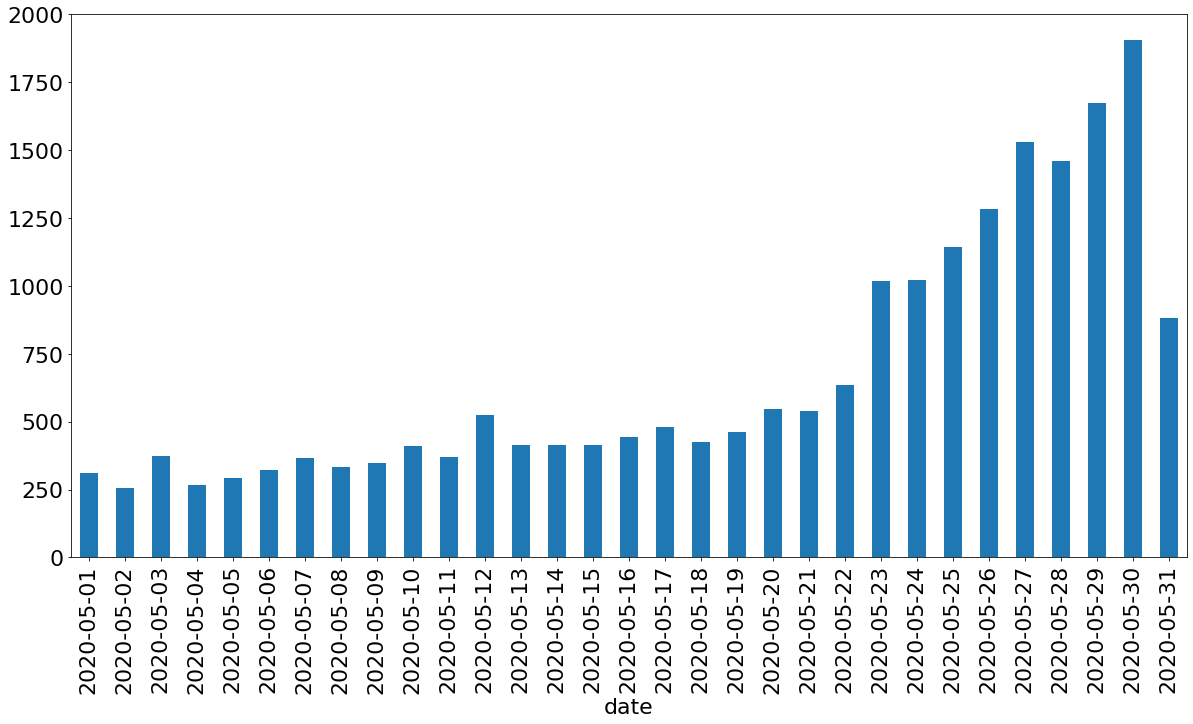

In [129]:
tweets.groupby('date').size().plot(kind='bar',figsize=(20,10))

## Who tweets the most?

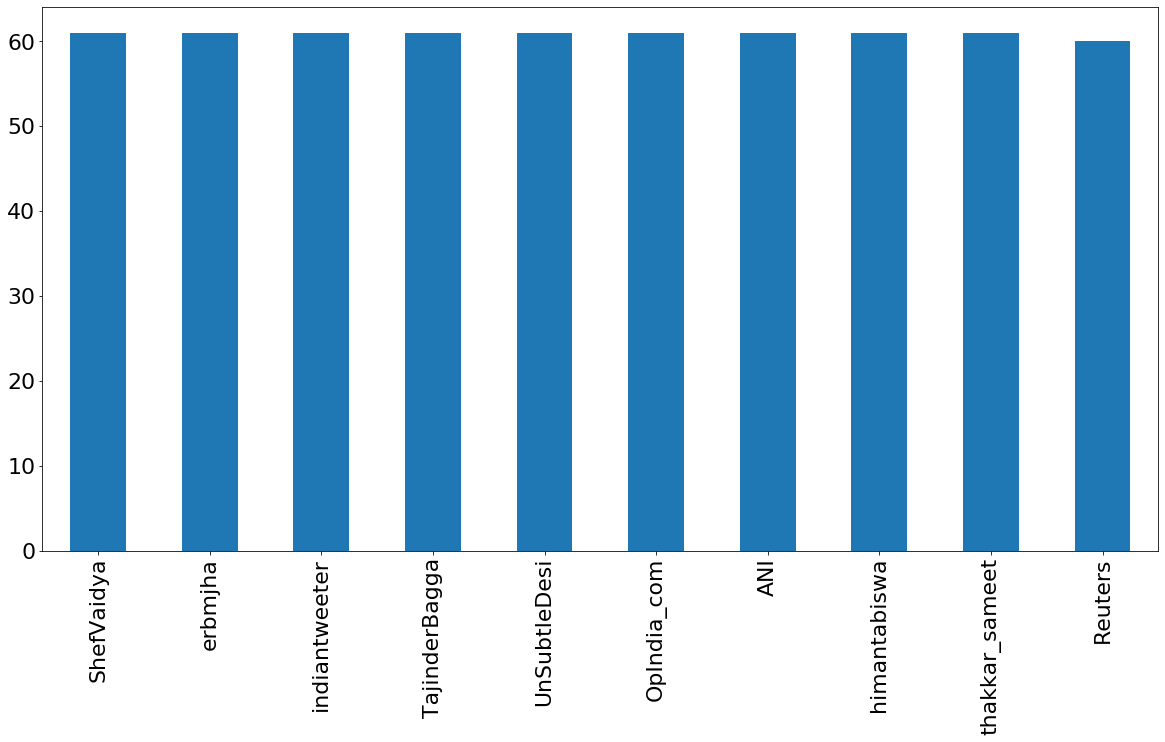

In [46]:
tweets['user'].value_counts().nlargest(10).plot(kind='bar',figsize=(20,10))

Usual suspects. Also I did put a limit of 60 tweets hence above is not very useful.

## What hashtags are involved?

In [59]:
hash_tag_regex = re.compile('(#\w+)\s')
tweets['hash_tag'] = tweets['tweet_text'].apply(lambda x: hash_tag_regex.findall(x))
tweets['hash_tag'] = tweets['hash_tag'].astype('str').str.replace("[","").str.replace("]","")

In [71]:
hash_tags = tweets['hash_tag'].unique().tolist()
print(f"Total of {len(hash_tags)} unique hashtags are available, data listed below",'\n')
print(hash_tags)

Total of 3008 unique hashtags are available, data listed below 

['', "'#JaiHind'", "'#ShameOnUddhavThackeray'", "'#ShameOnYouUddhavThackeray'", "'#BetaalReview'", "'#ShameOnBollywood'", "'#Shame'", "'#FailedUddhavThackeray'", "'#MahaRevenge'", "'#Ff'", "'#ChupRahoZulmSaho'", "'#SoniaSenaAgainstFarmers'", "'#faileduddhavThackeray'", "'#JaiMaharashtra', '#JaiHind'", "'#SoniaSenaInsultsSavarkar'", "'#BringItOn', '#JaiMaharashtra', '#JaiHind'", "'#LawLessMaharashtra'", "'#GameOn'", "'#SupportSanatanDeka'", "'#DonaldTrump'", "'#AntiFarmerSoniaSena'", "'#MNREGA'", "'#VizagGasLeak'", "'#IndiaFightsCorona'", "'#warmupdrills'", "'#parentslove', '#struggleisreal', '#dreambig'", "'#lovemommy', '#puresoul', '#foreverbest'", "'#daughterslove', '#happy', '#sweet'", "'#throwback'", "'#CycloneAmphan'", "'#Bollywood'", "'#1YearofModi2'", "'#VeerSavarkar'", "'#Bengaluru'", "'#MahaRanaPratapJayanti2020'", "'#IndiaStandwithBagga'", "'#ISupportTajinderBagga'", "'#HistoricOneYearOfModi2'", "'#AmphanCyclon'

In [63]:
tweets[tweets['hash_tag']!=""]['hash_tag'].value_counts().nlargest

'#COVID19'                    214
'#IndiaFightsCorona'          133
'#1YearofModi2'               103
'#1YearOfModi2'                80
'#MannKiBaat'                  78
                             ... 
'#AntiNationalRahulGandhi'      1
'#SachKaSaamna'                 1
'#car', '#Pulwama'              1
'#HinduTemples'                 1
'#ChangingLives'                1
Name: hash_tag, Length: 3007, dtype: int64

(-0.5, 399.5, 199.5, -0.5)

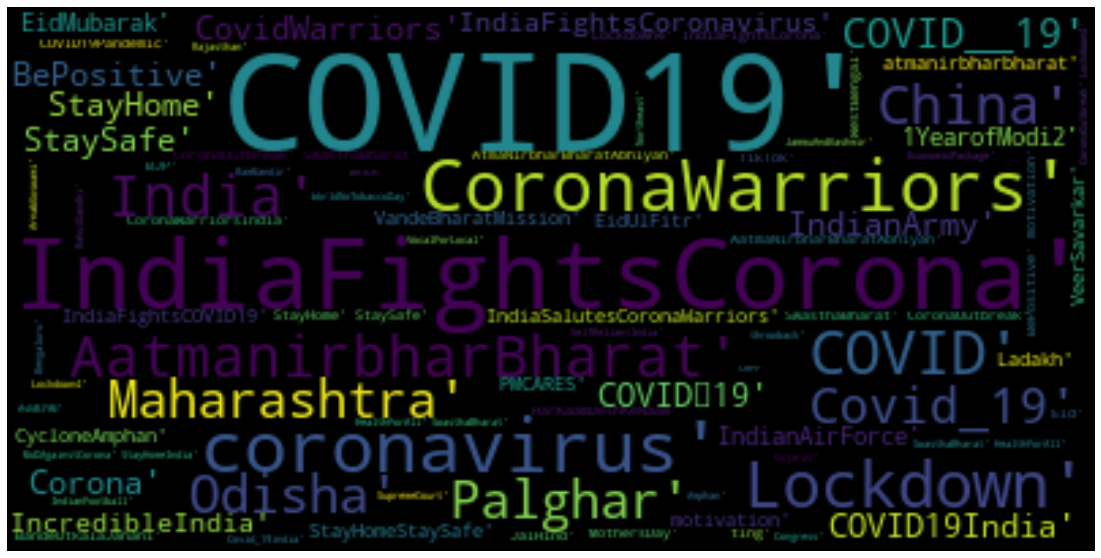

In [85]:
wc = wordcloud.WordCloud(max_words=1000).generate(",".join(hash_tags))

# Display the generated image:
plt.figure( figsize=(20,10) )
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

What would we see if there was no Covid?

In [105]:
hash_tags_wo_covid = tweets[(~tweets['hash_tag'].str.upper().str.contains("".join('CORONA|COVID|LOCK'))) & 
       (tweets['hash_tag']!="")]['hash_tag'].unique().tolist()

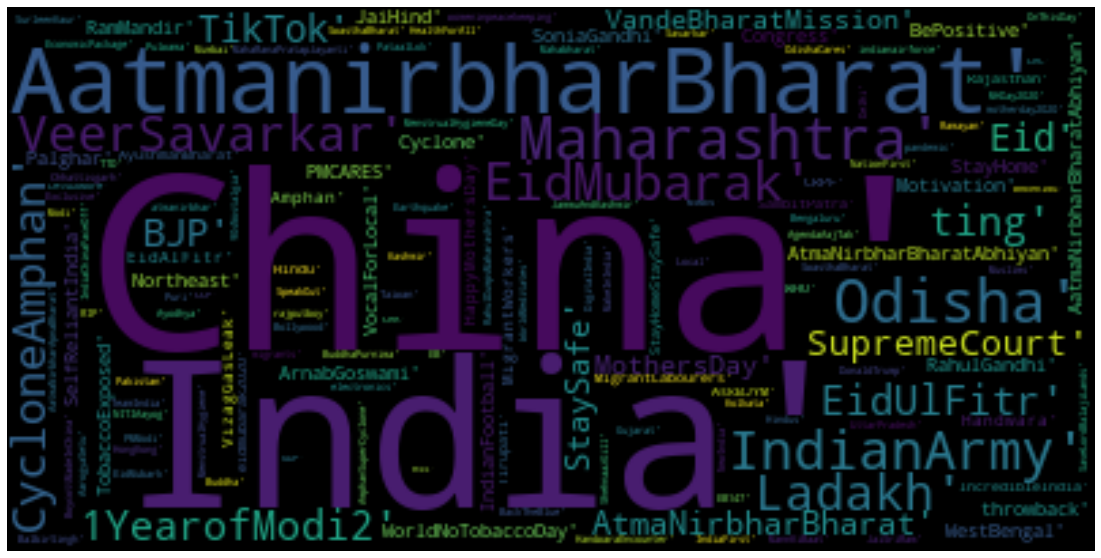

In [106]:
wc = wordcloud.WordCloud(max_words=1000).generate(",".join(hash_tags_wo_covid))
# Display the generated image:
plt.figure( figsize=(20,10) )
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Hmm strange that we have eid included.

In [114]:
tweets[tweets['hash_tag'].str.upper().str.contains('EID')].sample(5)

,tweet_id,date,user,tweet_text,hash_tag
8110,1264756952803864576,2020-05-25 03:15:30,sudarsansand,My SandArt on the occasion of #EidAlFitr with message #EidMubarak at puri beach in Odisha. pic.twitter.com/Uwl97tzHCH,"'#EidAlFitr', '#EidMubarak'"
7879,1264719019036143616,2020-05-25 00:44:46,crpfindia,"We wish you good health, happiness, and prosperity on this Eid-al-Fitr. #EidUlFitr #EidMubarak. pic.twitter.com/ih2NRRUApp",'#EidUlFitr'
1875,1264743679903686656,2020-05-25 02:22:45,DrPramodPSawant,Greetings and warm wishes to the people of Goa on the occasion of #EidUlFitr . pic.twitter.com/lXp7cCGC9r,'#EidUlFitr'
18620,1264559085262798848,2020-05-24 14:09:14,ShahnawazBJP,"May the Almighty Allah open the doors of opportunity, prosperity, happiness,success and Good Health for all in the world. #EidMubarak to you and your family.#eidmubarak2020",'#EidMubarak'
2873,1264810747294441473,2020-05-25 06:49:15,srikidambi,Wish Eid Mubarak to all of you! Celebrate with your loved ones indoors & stay safe. Have a great one! #EidMubarak pic.twitter.com/AZ7iWQ762L,'#EidMubarak'
